# Toy Data: 8-Modes Mixture Model

In [73]:
%matplotlib notebook
from time import time

import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom

import data
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [74]:
ndim_tot = 16
ndim_x = 2
ndim_y = 4
ndim_z = 2

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 256), nn.ReLU(),
                         nn.Linear(256,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(6):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':2.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False)
#model.load_state_dict(torch.load('fig_8_UR_INN.pt'))

<IPython.core.display.Javascript object>


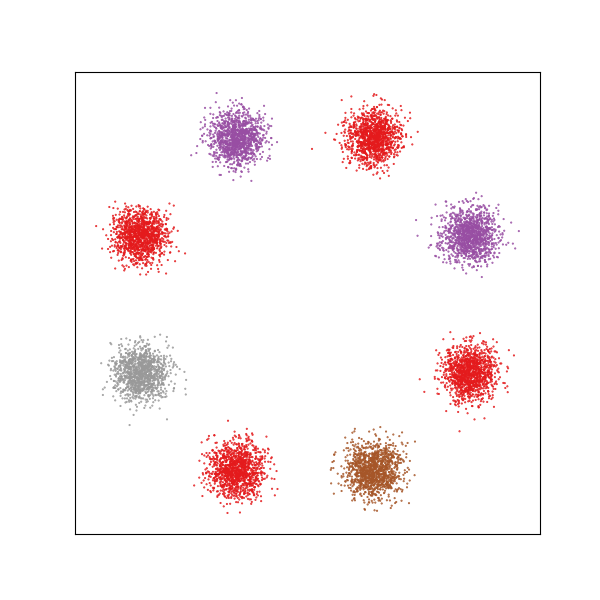

In [75]:
test_split = 10000

pos, labels = data.generate(
    labels='some2',
    tot_dataset_size=2**20
)
labels = labels[:,:ndim_y]

c = np.where(labels[:test_split])[1]
plt.figure(figsize=(6, 6))
plt.scatter(pos[:test_split, 0], pos[:test_split, 1], c=c, cmap='Set1', s=0.25)
plt.xticks([])
plt.yticks([])
plt.show()

In [76]:
# Training parameters
n_epochs = 200
n_its_per_epoch = 8
batch_size = 1600

lr = 1e-3
l2_reg = 1e-5

y_noise_scale = 1e-4
zeros_noise_scale = 1e-4
z_noise_scale = 1e-2

# relative weighting of losses:
lambd_predict = 35.
lambd_latent = 150.
lambd_rev = 200.
lambd_recon = 10.
loss_ramp = True


trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[:test_split], labels[:test_split]),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[test_split:], labels[test_split:]),
    batch_size=batch_size, shuffle=True, drop_last=True)

In [77]:
def train(i_epoch=0):
    model.train()

    l_tot = 0
    batch_idx = 0
    
    t_start = time()
    
    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.  
    if loss_ramp == True:
        loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))
    else:
        loss_factor = 1.
    for x, y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break

        x, y = x.to(device), y.to(device)
        
        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

        y += y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

        x, y = (torch.cat((x, pad_x),  dim=1),
                torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz, y),
                          dim=1))
        

        optimizer.zero_grad()

        # Forward step:

        output = model(x)

        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])

        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)

        l += lambd_latent * loss_latent(output_block_grad, y_short)
        l_tot += l.data.item()

        l.backward()

        # Backward step:
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)

        orig_z_perturbed = (output.data[:, :ndim_z] + z_noise_scale *
                            torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz,
                           output.data[:, -ndim_y:]+ y_noise_scale* torch.randn(batch_size, ndim_y, device=device)), dim=1)
        y_rev_rand = torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz,
                                y), dim=1)
        
        output_rev = model(y_rev, rev=True)
        output_rev_rand = model(y_rev_rand, rev=True)

        l_rev = (
            lambd_rev
            * loss_factor
            * loss_backward(output_rev_rand[:, :ndim_x],
                            x[:, :ndim_x])
        )

        l_rev += lambd_recon * loss_fit(output_rev, x)
        
        l_tot += l_rev.data.item()
        l_rev.backward()

        for p in model.parameters():
            p.grad.data.clamp_(-15.00, 15.00)

        optimizer.step()

    return l_tot / batch_idx

<IPython.core.display.Javascript object>


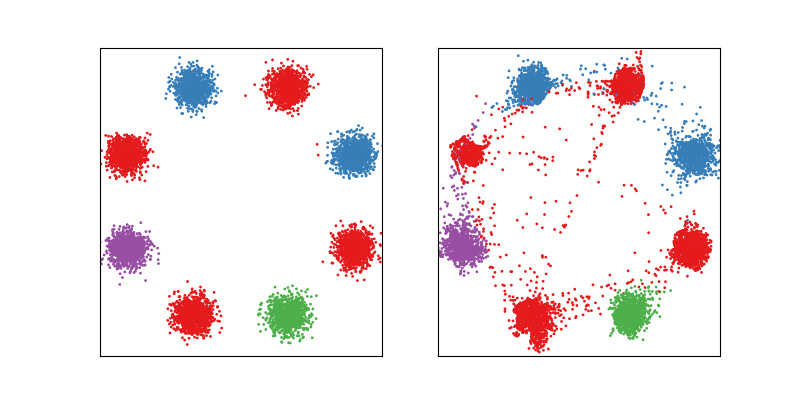






  0%|                                                   | 0/200 [00:00<?, ?it/s]




  0%|2                                          | 1/200 [00:02<07:45,  2.34s/it]




  1%|4                                          | 2/200 [00:04<07:28,  2.27s/it]




  2%|6                                          | 3/200 [00:06<07:09,  2.18s/it]




  2%|8                                          | 4/200 [00:08<07:16,  2.23s/it]




  2%|#                                          | 5/200 [00:10<07:08,  2.20s/it]




  3%|#2                                         | 6/200 [00:12<06:50,  2.11s/it]




  4%|#5                                         | 7/200 [00:14<06:37,  2.06s/it]




  4%|#7                                         | 8/200 [00:16<06:24,  2.00s/it]




  4%|#9                                         | 9/200 [00:18<06:16,  1.97s/it]




  5%|##1                                       | 10/200 [00:20<06:13,  1.97s/it]




  6%|##3                                       | 11/200 [00:

 40%|#################                         | 81/200 [03:19<05:10,  2.61s/it]




 41%|#################2                        | 82/200 [03:22<05:08,  2.61s/it]




 42%|#################4                        | 83/200 [03:24<05:15,  2.70s/it]




 42%|#################6                        | 84/200 [03:27<05:19,  2.75s/it]




 42%|#################8                        | 85/200 [03:30<05:10,  2.70s/it]




 43%|##################                        | 86/200 [03:33<05:05,  2.68s/it]




 44%|##################2                       | 87/200 [03:35<05:02,  2.68s/it]




 44%|##################4                       | 88/200 [03:38<05:05,  2.73s/it]




 44%|##################6                       | 89/200 [03:41<04:57,  2.68s/it]




 45%|##################9                       | 90/200 [03:43<04:51,  2.65s/it]




 46%|###################1                      | 91/200 [03:46<04:49,  2.65s/it]




 46%|###################3                      | 92/200 [03:49<04

 81%|#################################2       | 162/200 [06:53<01:25,  2.24s/it]




 82%|#################################4       | 163/200 [06:56<01:26,  2.35s/it]




 82%|#################################6       | 164/200 [06:59<01:27,  2.42s/it]




 82%|#################################8       | 165/200 [07:01<01:26,  2.48s/it]




 83%|##################################       | 166/200 [07:04<01:25,  2.50s/it]




 84%|##################################2      | 167/200 [07:06<01:23,  2.54s/it]




 84%|##################################4      | 168/200 [07:09<01:23,  2.61s/it]




 84%|##################################6      | 169/200 [07:12<01:20,  2.59s/it]




 85%|##################################8      | 170/200 [07:14<01:17,  2.59s/it]




 86%|###################################      | 171/200 [07:17<01:14,  2.57s/it]




 86%|###################################2     | 172/200 [07:20<01:12,  2.59s/it]




 86%|###################################4     | 173/200 [07:22<01



Training took 8.55 minutes



In [78]:
for param in trainable_parameters:
    param.data = 0.10*torch.randn_like(param)
            
model.to(device)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += 0 * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, -4:].argmax(dim=1)
        
        z_val = model(torch.cat((x_samps, torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))

        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3,3,-3,3])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3,3,-3,3])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [79]:
n_epochs = 400
lambd_predict = 10.
lambd_latent = 150.
lambd_rev = 250.
loss_ramp = False

lr = 6e-4
l2_reg = 5e-5


for g in optimizer.param_groups:
    g['lr'] = lr
    g['weight_decay'] = l2_reg 
        


<IPython.core.display.Javascript object>


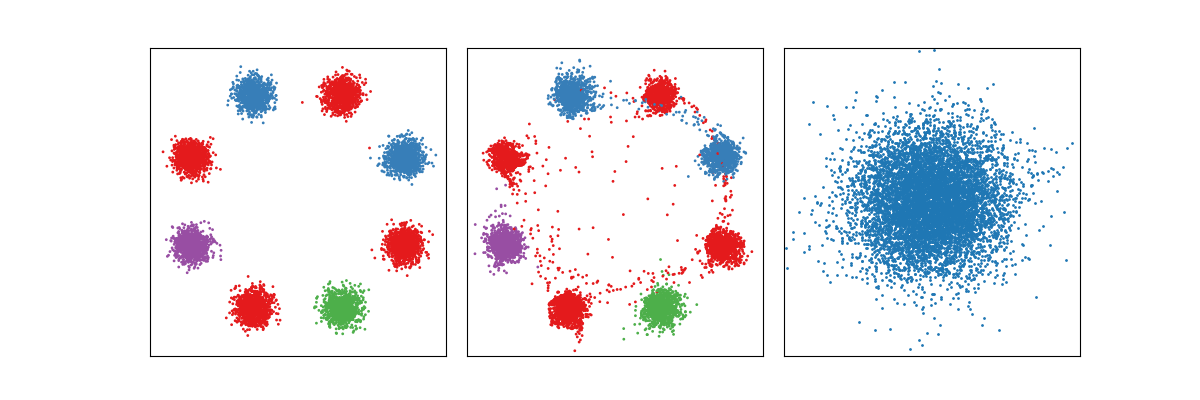






  0%|                                                   | 0/400 [00:00<?, ?it/s]




  0%|1                                          | 1/400 [00:02<14:06,  2.12s/it]




  0%|2                                          | 2/400 [00:04<14:25,  2.17s/it]




  1%|3                                          | 3/400 [00:06<14:42,  2.22s/it]




  1%|4                                          | 4/400 [00:09<14:53,  2.26s/it]




  1%|5                                          | 5/400 [00:11<15:29,  2.35s/it]




  2%|6                                          | 6/400 [00:14<15:55,  2.43s/it]




  2%|7                                          | 7/400 [00:16<16:27,  2.51s/it]




  2%|8                                          | 8/400 [00:19<16:47,  2.57s/it]




  2%|9                                          | 9/400 [00:22<17:04,  2.62s/it]




  2%|#                                         | 10/400 [00:25<17:18,  2.66s/it]




  3%|#1                                        | 11/400 [00:

 20%|########5                                 | 81/400 [03:21<10:47,  2.03s/it]




 20%|########6                                 | 82/400 [03:23<10:41,  2.02s/it]




 21%|########7                                 | 83/400 [03:25<10:38,  2.02s/it]




 21%|########8                                 | 84/400 [03:27<10:55,  2.07s/it]




 21%|########9                                 | 85/400 [03:30<12:22,  2.36s/it]




 22%|#########                                 | 86/400 [03:33<13:22,  2.55s/it]




 22%|#########1                                | 87/400 [03:36<13:21,  2.56s/it]




 22%|#########2                                | 88/400 [03:38<13:25,  2.58s/it]




 22%|#########3                                | 89/400 [03:41<13:28,  2.60s/it]




 22%|#########4                                | 90/400 [03:43<13:18,  2.57s/it]




 23%|#########5                                | 91/400 [03:46<13:05,  2.54s/it]




 23%|#########6                                | 92/400 [03:48<12

 40%|################6                        | 162/400 [06:34<08:29,  2.14s/it]




 41%|################7                        | 163/400 [06:36<08:18,  2.10s/it]




 41%|################8                        | 164/400 [06:38<08:10,  2.08s/it]




 41%|################9                        | 165/400 [06:40<08:10,  2.09s/it]




 42%|#################                        | 166/400 [06:42<08:54,  2.28s/it]




 42%|#################1                       | 167/400 [06:45<09:11,  2.37s/it]




 42%|#################2                       | 168/400 [06:48<09:38,  2.49s/it]




 42%|#################3                       | 169/400 [06:50<09:42,  2.52s/it]




 42%|#################4                       | 170/400 [06:53<10:09,  2.65s/it]




 43%|#################5                       | 171/400 [06:56<10:01,  2.63s/it]




 43%|#################6                       | 172/400 [06:59<10:02,  2.64s/it]




 43%|#################7                       | 173/400 [07:01<09

 61%|########################9                | 243/400 [10:09<07:32,  2.88s/it]




 61%|#########################                | 244/400 [10:12<07:26,  2.86s/it]




 61%|#########################1               | 245/400 [10:15<07:16,  2.82s/it]




 62%|#########################2               | 246/400 [10:17<07:12,  2.81s/it]




 62%|#########################3               | 247/400 [10:20<07:06,  2.79s/it]




 62%|#########################4               | 248/400 [10:23<07:07,  2.81s/it]




 62%|#########################5               | 249/400 [10:26<07:04,  2.81s/it]




 62%|#########################6               | 250/400 [10:29<06:55,  2.77s/it]




 63%|#########################7               | 251/400 [10:31<06:58,  2.81s/it]




 63%|#########################8               | 252/400 [10:34<06:57,  2.82s/it]




 63%|#########################9               | 253/400 [10:37<06:58,  2.85s/it]




 64%|##########################               | 254/400 [10:40<06

 81%|#################################2       | 324/400 [13:35<03:31,  2.78s/it]




 81%|#################################3       | 325/400 [13:37<03:23,  2.72s/it]




 82%|#################################4       | 326/400 [13:40<03:18,  2.68s/it]




 82%|#################################5       | 327/400 [13:43<03:12,  2.64s/it]




 82%|#################################6       | 328/400 [13:45<03:09,  2.63s/it]




 82%|#################################7       | 329/400 [13:47<02:57,  2.50s/it]




 82%|#################################8       | 330/400 [13:49<02:44,  2.35s/it]




 83%|#################################9       | 331/400 [13:51<02:35,  2.25s/it]




 83%|##################################       | 332/400 [13:53<02:30,  2.21s/it]




 83%|##################################1      | 333/400 [13:56<02:35,  2.31s/it]




 84%|##################################2      | 334/400 [13:59<02:37,  2.39s/it]




 84%|##################################3      | 335/400 [14:01<02



Training took 16.60 minutes



In [80]:
model.to(device)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += 0 * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, -4:].argmax(dim=1)
        
        z_val = model(torch.cat((x_samps, torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))

        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:,0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].axis([-4,4,-4,4])
        axes[2].set_xticks([])
        axes[2].set_yticks([])

        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [63]:
n_epochs = 100
lr = 1e-4
l2_reg = 5e-5


for g in optimizer.param_groups:
    g['lr'] = lr
    g['weight_decay'] = l2_reg 
        

<IPython.core.display.Javascript object>


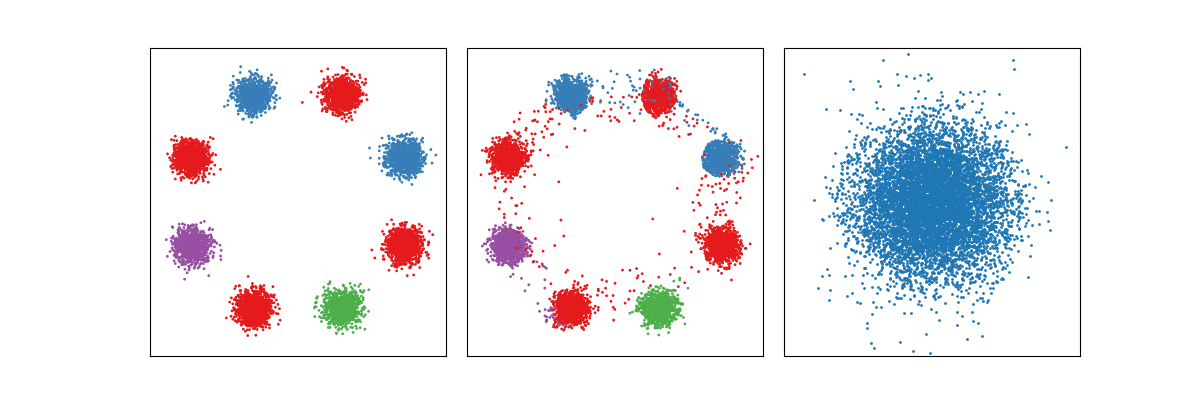





  0%|                                                   | 0/100 [00:00<?, ?it/s]



  1%|4                                          | 1/100 [00:02<04:09,  2.52s/it]



Training took 0.04 minutes



In [64]:
model.to(device)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += 0 * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, -4:].argmax(dim=1)
        
        z_val = model(torch.cat((x_samps, torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))

        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:,0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].axis([-4,4,-4,4])
        axes[2].set_xticks([])
        axes[2].set_yticks([])

        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")